In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import warnings
import datetime
import json
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from model_generator import *

#### Read aemet forecast and band price

In [3]:
aemet = pd.read_csv('Province_prediction_text/merged.csv', encoding='latin1')

In [4]:
aemet_daily_forecast = aemet.groupby(['date'])['prediction'].apply(', '.join).to_frame()

In [5]:
paths_dict_band = json.load(open('paths_dict_band.json', 'r'))

In [6]:
band_model = generate_df(paths_dict_band, 'band')

In [7]:
band = band_model.return_completed_df()

In [8]:
aemet_band = aemet_daily_forecast.merge(band.groupby('date')[['band']].mean().rename(columns={'band':'mean'}), how='left', left_index=True,
                           right_index=True)
aemet_band = aemet_band.merge(band.groupby('date')[['band']].std().rename(columns={'band':'std'}), how='left',
                            left_index=True, right_index=True)

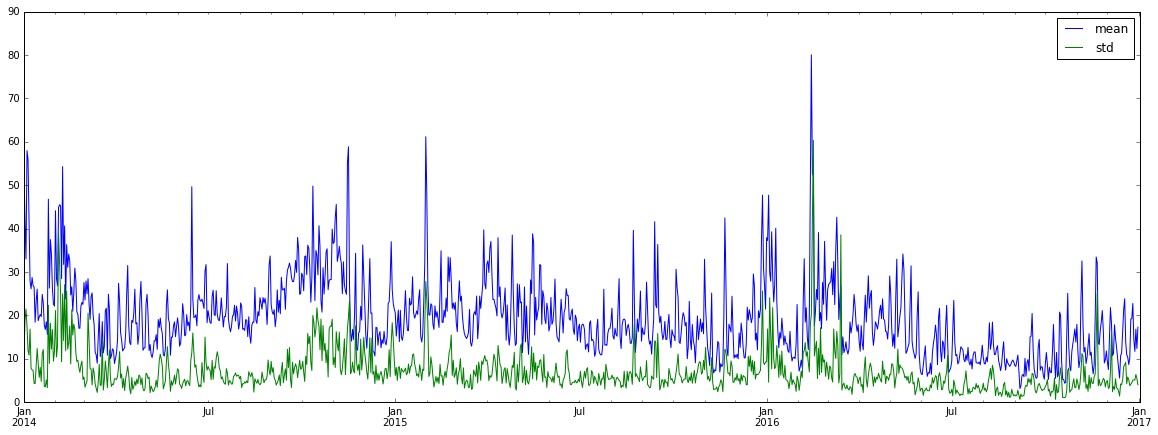

In [9]:
aemet_band[['mean', 'std']].plot(figsize=(20,7));

#### Create pipeline to predict daily vol/mean based on weather forecast

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
pipeline_mean = make_pipeline(
        TfidfVectorizer(stop_words='english',
                       min_df=5,
                       max_df=0.95,
                       strip_accents='unicode',
                       norm='l2',
                       sublinear_tf=True,),
        SelectFromModel(Lasso(alpha=0.001, random_state=0)),
        Ridge(alpha=1, random_state=0))

In [12]:
mean_model = train_model(df=aemet_band[aemet_band.index < '2017'], features='prediction', output='mean', features_to_remove=[],
                         n_folds=5)

volatility: alpha_lasso=0.01; alpha_rdige=1
mean: alpah_lasso=0.001; alpha_rdige=1

In [13]:
mean_model.obtain_cv_score(pipeline_mean)

Mean absolute error: 4.9984 +- 0.2715
Mean squared error: 48.2721 +- 7.8102


In [14]:
mean_model.obtain_train_test_error(pipeline_mean)

Train MAE: 3.91971336992, Train MSE: 28.9635971958
Test MAE: 4.96922853683, Test MSE: 40.6573580595


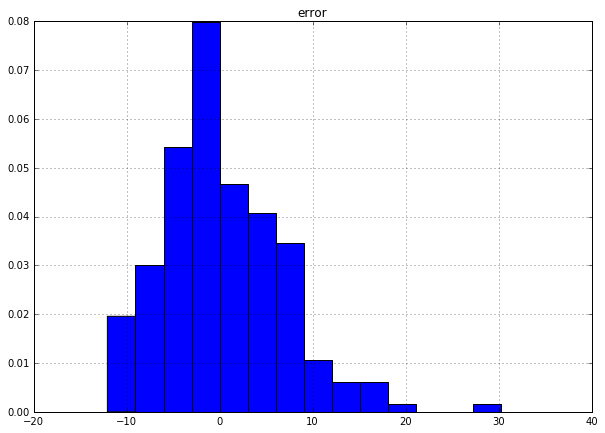

In [15]:
mean_model.plot_histogram_error()

In [16]:
pipeline_vol = make_pipeline(
        TfidfVectorizer(stop_words='english',
                       min_df=5,
                       max_df=0.95,
                       strip_accents='unicode',
                       norm='l2',
                       sublinear_tf=True,),
        SelectFromModel(Lasso(alpha=0.01, random_state=0)),
        Ridge(alpha=1, random_state=0))

In [17]:
volatility_model = train_model(df=aemet_band[aemet_band.index < '2017'], features='prediction', 
                              output='std', features_to_remove=[], n_folds=5)

In [18]:
volatility_model.obtain_cv_score(pipeline_vol)

Mean absolute error: 2.6122 +- 0.4704
Mean squared error: 15.3758 +- 7.8281


In [19]:
volatility_model.obtain_train_test_error(pipeline_vol)

Train MAE: 2.46763267755, Train MSE: 13.488847511
Test MAE: 2.61754721866, Test MSE: 23.8835126448


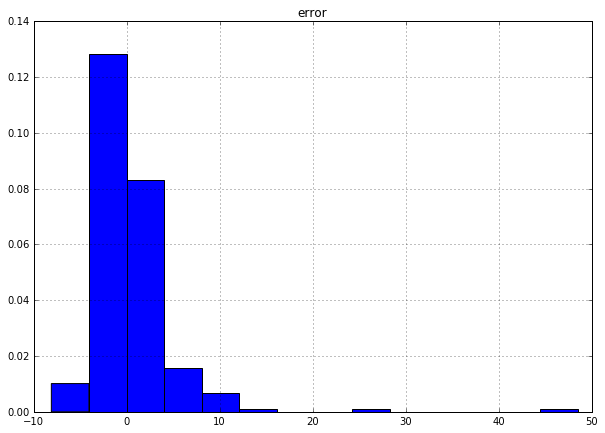

In [20]:
volatility_model.plot_histogram_error()

### Meta-model 

In [21]:
mean_metamodel = metamodel(features='prediction', pipeline=pipeline_mean, 
                           n_folds=5, num_cv=4, metric={'mae': mean_absolute_error,
                                                        'mse': mean_squared_error})

In [22]:
index, oos_mean = mean_metamodel.get_oos_cv_predictions(x_train=aemet_band[aemet_band.index < '2017'].reset_index(),
                                                       y_train = aemet_band[aemet_band.index < '2017']['mean'].values,
                                                       index_col='index')

CV number:  1
Acting in fold 1 on 1
Acting in fold 2 on 1
Acting in fold 3 on 1
Acting in fold 4 on 1
Acting in fold 5 on 1
mae on 1 CV: 4.9031 +- 0.3849
mse on 1 CV: 44.6518 +- 4.4171
CV number:  2
Acting in fold 1 on 2
Acting in fold 2 on 2
Acting in fold 3 on 2
Acting in fold 4 on 2
Acting in fold 5 on 2
mae on 2 CV: 4.9442 +- 0.7463
mse on 2 CV: 45.0902 +- 16.5852
CV number:  3
Acting in fold 1 on 3
Acting in fold 2 on 3
Acting in fold 3 on 3
Acting in fold 4 on 3
Acting in fold 5 on 3
mae on 3 CV: 5.0558 +- 0.3297
mse on 3 CV: 47.1289 +- 11.7192
CV number:  4
Acting in fold 1 on 4
Acting in fold 2 on 4
Acting in fold 3 on 4
Acting in fold 4 on 4
Acting in fold 5 on 4
mae on 4 CV: 4.9461 +- 0.3944
mse on 4 CV: 45.1971 +- 15.4028


In [28]:
vol_metamodel = metamodel(features='prediction', pipeline=pipeline_vol, 
                           n_folds=5, num_cv=4, metric={'mae': mean_absolute_error,
                                                        'mse': mean_squared_error})

In [31]:
index, oos_vol = vol_metamodel.get_oos_cv_predictions(x_train=aemet_band[aemet_band.index < '2017'].reset_index(),
                            y_train = aemet_band[aemet_band.index < '2017']['std'].values,
                            index_col='index')

CV number:  1
Acting in fold 1 on 1
Acting in fold 2 on 1
Acting in fold 3 on 1
Acting in fold 4 on 1
Acting in fold 5 on 1
mae on 1 CV: 2.6529 +- 0.3596
mse on 1 CV: 17.0513 +- 9.3955
CV number:  2
Acting in fold 1 on 2
Acting in fold 2 on 2
Acting in fold 3 on 2
Acting in fold 4 on 2
Acting in fold 5 on 2
mae on 2 CV: 2.6422 +- 0.2911
mse on 2 CV: 17.1875 +- 9.7897
CV number:  3
Acting in fold 1 on 3
Acting in fold 2 on 3
Acting in fold 3 on 3
Acting in fold 4 on 3
Acting in fold 5 on 3
mae on 3 CV: 2.6569 +- 0.5532
mse on 3 CV: 17.3611 +- 15.1472
CV number:  4
Acting in fold 1 on 4
Acting in fold 2 on 4
Acting in fold 3 on 4
Acting in fold 4 on 4
Acting in fold 5 on 4
mae on 4 CV: 2.6526 +- 0.3479
mse on 4 CV: 17.2127 +- 10.8209


In [33]:
pd.DataFrame({'pred_band_mean_aemet':oos_mean, 'pred_band_vol_aemet':oos_vol},
            index=index).to_csv('band_mean_vol_pred_aemet.csv')